# Learn Trotting Direct

Learning simple trotting under disturbance, by learning:
- COM traj
- Inverse Dynamics
- Configurations

In [1]:
import sys, os
sys.path.append('../lib')
import time
import numpy.matlib
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import pybullet as p
import pybullet_data
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

from pb_utils.visualize import set_q, vis_traj, plot_compare
from sl1m_env import load_robot_pinocchio

from anymal_utils import extract_contact_poses_from_poses, extract_contact_phase, extract_mpc_contact_sequence, compute_foot_pose, create_lqt_init
from anymal_utils import create_gait_trot
from sl1m_env import setup_pybullet
from regression import bezier, rbf
from ocp import finiteLQT
from ocp_sys import LinearSystem

import crocoddyl
from crocoddyl.utils.quadruped import plotSolution
from caracal.gaits import QuadrupedalGaitGenerator
from caracal.utils import plotContactPhaseDiagram
from caracal.params import SolverType
import caracal
import example_robot_data
import pinocchio
import copy


pybullet build time: Mar 26 2022 03:00:52


In [2]:
which_computer = 'idiap' #'laptop'
if which_computer == 'laptop':
    urdf_name = '/opt/openrobots/share/example-robot-data/robots/anymal_b_simple_description/robots/anymal.urdf'
    env_name = '../env/urdf/full_stair_small.urdf'
    mpc_filename = '/home/teguh/git/memmo/memmo_talos/anymal/generate_data_trot/data/config/mpc_params.yaml'
    DATA_ROOT = '/media/teguh/Data2/anymal_data/'
else:
    urdf_name = '/idiap/temp/tlembono/miniconda3/envs/robotpkg/share/example-robot-data/robots/anymal_b_simple_description/robots/anymal.urdf'
    env_name = '../env/urdf/full_stair_small.urdf'
    mpc_filename = '/idiap/temp/tlembono/git/memmo_talos/anymal/generate_data_trot/data/config/mpc_params.yaml'
    DATA_ROOT = '/idiap/temp/tlembono/data_new/'

#### Determine the environment
env_name = '../env/urdf/full_stair_small_0.15.urdf'

PROJECT_PATH = DATA_ROOT + 'gianni_new_w504.0_w_pen0.0/'+ env_name[12:-5] + '/10_iter_60_horizon/'

END_TRAJ = 945-60
MPC_HORIZON = 60
N_MPC_STEPS = END_TRAJ
stepHeight = 0.12
N_ss = 30
N_ds = 45

ws = np.ones((N_ss,2))
ws[:,0] *= 1e6
ws[:,1] *= 1e4
%load_ext autoreload
%autoreload 2

#### Start Pybullet

In [3]:
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

robot_id, plane_id, env_id = setup_pybullet(urdf_name, env_name)

rmodel, rdata, q0, v0, rh_id, rf_id, lh_id, lf_id = load_robot_pinocchio()
pb_joint_indices = np.array([1, 2, 3, 11, 12, 13, 6, 7, 8, 16, 17, 18])
set_q_std = partial(set_q, robot_id = robot_id, joint_indices=pb_joint_indices, set_base = True)
vis_traj_std = partial(vis_traj, vis_func=set_q_std, dt = 0.001)

/idiap/temp/tlembono/miniconda3/envs/robotpkg/lib/python3.8/site-packages/pinocchio/shortcuts.py:45: UserWarning: You passed package dir(s) via argument geometry_model and provided package_dirs.
  geom_model = pin.buildGeomFromUrdf(model, filename, geometry_type, package_dirs)


#### Load data

In [4]:
filenames = os.listdir(PROJECT_PATH)
filenames = [name for name in filenames if name[-3:] == 'npz']

data = []
for i,name in enumerate(filenames[:]):
    print(i)
    data_i = np.load(PROJECT_PATH+name, allow_pickle=True)['res'][()]
    data += [data_i]
clear_output()

xs_set = np.array([data_i['xs'][:END_TRAJ] for data_i in data]) #state trajectory for N experiments
us_set = np.array([data_i['us'][:END_TRAJ] for data_i in data]) #control trajectory for N experiments
xs_ref_set = np.array([data_i['xs_ref'][:END_TRAJ] for data_i in data]) #state trajectory output from MPC for N experiments and M time steps
us_ref_set = np.array([data_i['us_ref'][:END_TRAJ] for data_i in data]) #control trajectory output from MPC for N experiments and M time steps

N = len(data)
M = xs_ref_set.shape[1]
dof = 19

foot_step_set = np.array([[[compute_foot_pose(rmodel, rdata, xs_ref_set[i,j,k][:19]) for k in range(MPC_HORIZON)] for j in range(M)] for i in range(N)])

## Part 1: Given current config, predict the COM traj

#### Calculate contact sequence information for the current mpc time step
contact_input: mpc_phase, first_interval, target_contact_pose

In [53]:
#depends on the gait phase and the horizon length
TOTAL_PHASE = 12
TOTAL_POSE = 30

#given the time t and horizon T, obtain:a
#next N contact phases
#current time interval
#next N contact pose
#total_phase = 4 x 4indices/phase
#total_pose: 12 initial, +6x4phases for trotting
num_of_contact_pose = 6 #number of data for 1 contact pose (for double support phase). 3 for walking, 6 for trotting
to_load = False

if not to_load:
    contact_inputs = []
    for i in range(len(data)):
        print(i)
        #Collect these at the beginning of each traj
        xs, cs, foot_poses = data[i]['xs'][:END_TRAJ], data[i]['cs'][:END_TRAJ], data[i]['foot_poses'][:END_TRAJ+MPC_HORIZON]
        gait = create_gait_trot(cs, data[i]['N_ds'], N_ss, stepHeight, ws)
        contact_phases = extract_contact_phase(gait, MPC_HORIZON)[:END_TRAJ]#contact phase at each time step
        contact_poses, target_contact_poses = extract_contact_poses_from_poses(gait, foot_poses.T, MPC_HORIZON ) #Contact pose and its target at each time step
        for t0 in range(N_MPC_STEPS):
            x0 = xs[t0]
            mpc_phase, first_interval, target_contact_pose = extract_mpc_contact_sequence(t0, x0, contact_phases, target_contact_poses, num_of_contact_pose, 
                                                                                  MPC_HORIZON,  rmodel, rdata,  total_phase=TOTAL_PHASE, total_pose=TOTAL_POSE)
            #mpc_phase: phase indices for the next (max) 4 phases, including the current one
            #first interval: the remaining time step for the current phase
            #target_contact_pose: the target poses for the current horizon
            contact_input = np.concatenate([mpc_phase[:4], [first_interval], target_contact_pose])
            contact_inputs.append(contact_input)
    contact_inputs = np.array(contact_inputs)
    if os.path.exists(PROJECT_PATH + 'model_direct/') is False:
        os.makedirs(PROJECT_PATH + 'model_direct/')
    np.save(PROJECT_PATH + 'model_direct/contact_inputs_5iter_pybullet.npy', contact_inputs)
else:
    contact_inputs = np.load(PROJECT_PATH + 'model_direct/contact_inputs_5iter_pybullet.npy', allow_pickle=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


In [54]:
to_load = False

## Construct the input

Input:
- q, +base velocity
- contact_input: mpc_phase, first_interval, target_contact_poses

Output:
- whole body trajectory

In [55]:
shape_us = us_ref_set.shape

In [56]:
us_ref_set_new = np.zeros((shape_us[0], shape_us[1], shape_us[2], 12))

In [57]:
for i in range(us_ref_set.shape[0]):
    for j in range(us_ref_set.shape[1]):
        for k,u in enumerate(us_ref_set[i,j]):
            if len(u) == 0: 
                # print(len(u))
                us_ref_set[i,j,k] = us_ref_set[i,j,k-1]
        us_ref_set_new[i,j] = np.vstack(us_ref_set[i,j])

In [69]:
D_com = 19
D_control = 12
x_input_com = xs_ref_set[:,:,0,:].reshape(-1, 37)[:,np.r_[:19, 19:22]]
x_input_com = np.concatenate([x_input_com, contact_inputs], axis=1) #include mpc_phases and first_interval

x_output_com = xs_ref_set[:,:,:,:D_com].reshape(-1, MPC_HORIZON*D_com).copy()
x_output_control = us_ref_set_new[:,:,:,:D_control].reshape(-1, (MPC_HORIZON-1)*D_control).copy()

#### Split

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x_input_com, x_output_com, test_size = 0.2, random_state = 0)

pca_relative = PCA(40)
y_train_pca = pca_relative.fit_transform(y_train)

In [71]:
if to_load:
    pca_relative = pickle.load(open(PROJECT_PATH + 'model_direct/pca_trot_relative.pkl', 'rb'))
else:
    pickle.dump(pca_relative, open(PROJECT_PATH + 'model_direct/pca_trot_relative.pkl', 'wb'))

#### Create a model

In [72]:
D_in = x_train.shape[1]
D_out = y_train_pca.shape[1]

model_com_traj_relative = Sequential([
        GaussianNoise(0.01, input_shape=(D_in,)),
        Dense(256, activation='relu', input_shape=(D_in,)),
        Dense(256, activation='relu'),
        Dense(D_out)]
)

model_com_traj_relative.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.MSE)

In [73]:
if not to_load:
    history = model_com_traj_relative.fit(x_train, y_train_pca, batch_size=128, epochs=300, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])
    model_com_traj_relative.save(PROJECT_PATH + 'model_direct/predict_com_relative.h5')
else:
    model_com_traj_relative = tf.keras.models.load_model(PROJECT_PATH + 'model_direct/predict_com_relative.h5')

Epoch 1/300
540/540 [==============================] - 1s 2ms/step - loss: 0.5553 - val_loss: 0.3368
Epoch 2/300
540/540 [==============================] - 1s 2ms/step - loss: 0.2804 - val_loss: 0.2407
Epoch 3/300
540/540 [==============================] - 1s 2ms/step - loss: 0.2213 - val_loss: 0.2009
Epoch 4/300
540/540 [==============================] - 1s 2ms/step - loss: 0.1894 - val_loss: 0.1741
Epoch 5/300
540/540 [==============================] - 1s 2ms/step - loss: 0.1660 - val_loss: 0.1541
Epoch 6/300
540/540 [==============================] - 1s 2ms/step - loss: 0.1483 - val_loss: 0.1389
Epoch 7/300
540/540 [==============================] - 1s 2ms/step - loss: 0.1347 - val_loss: 0.1266
Epoch 8/300
540/540 [==============================] - 1s 2ms/step - loss: 0.1243 - val_loss: 0.1177
Epoch 9/300
540/540 [==============================] - 1s 2ms/step - loss: 0.1158 - val_loss: 0.1095
Epoch 10/300
540/540 [==============================] - 1s 2ms/step - loss: 0.1088 - val_lo

#### Test COM prediction

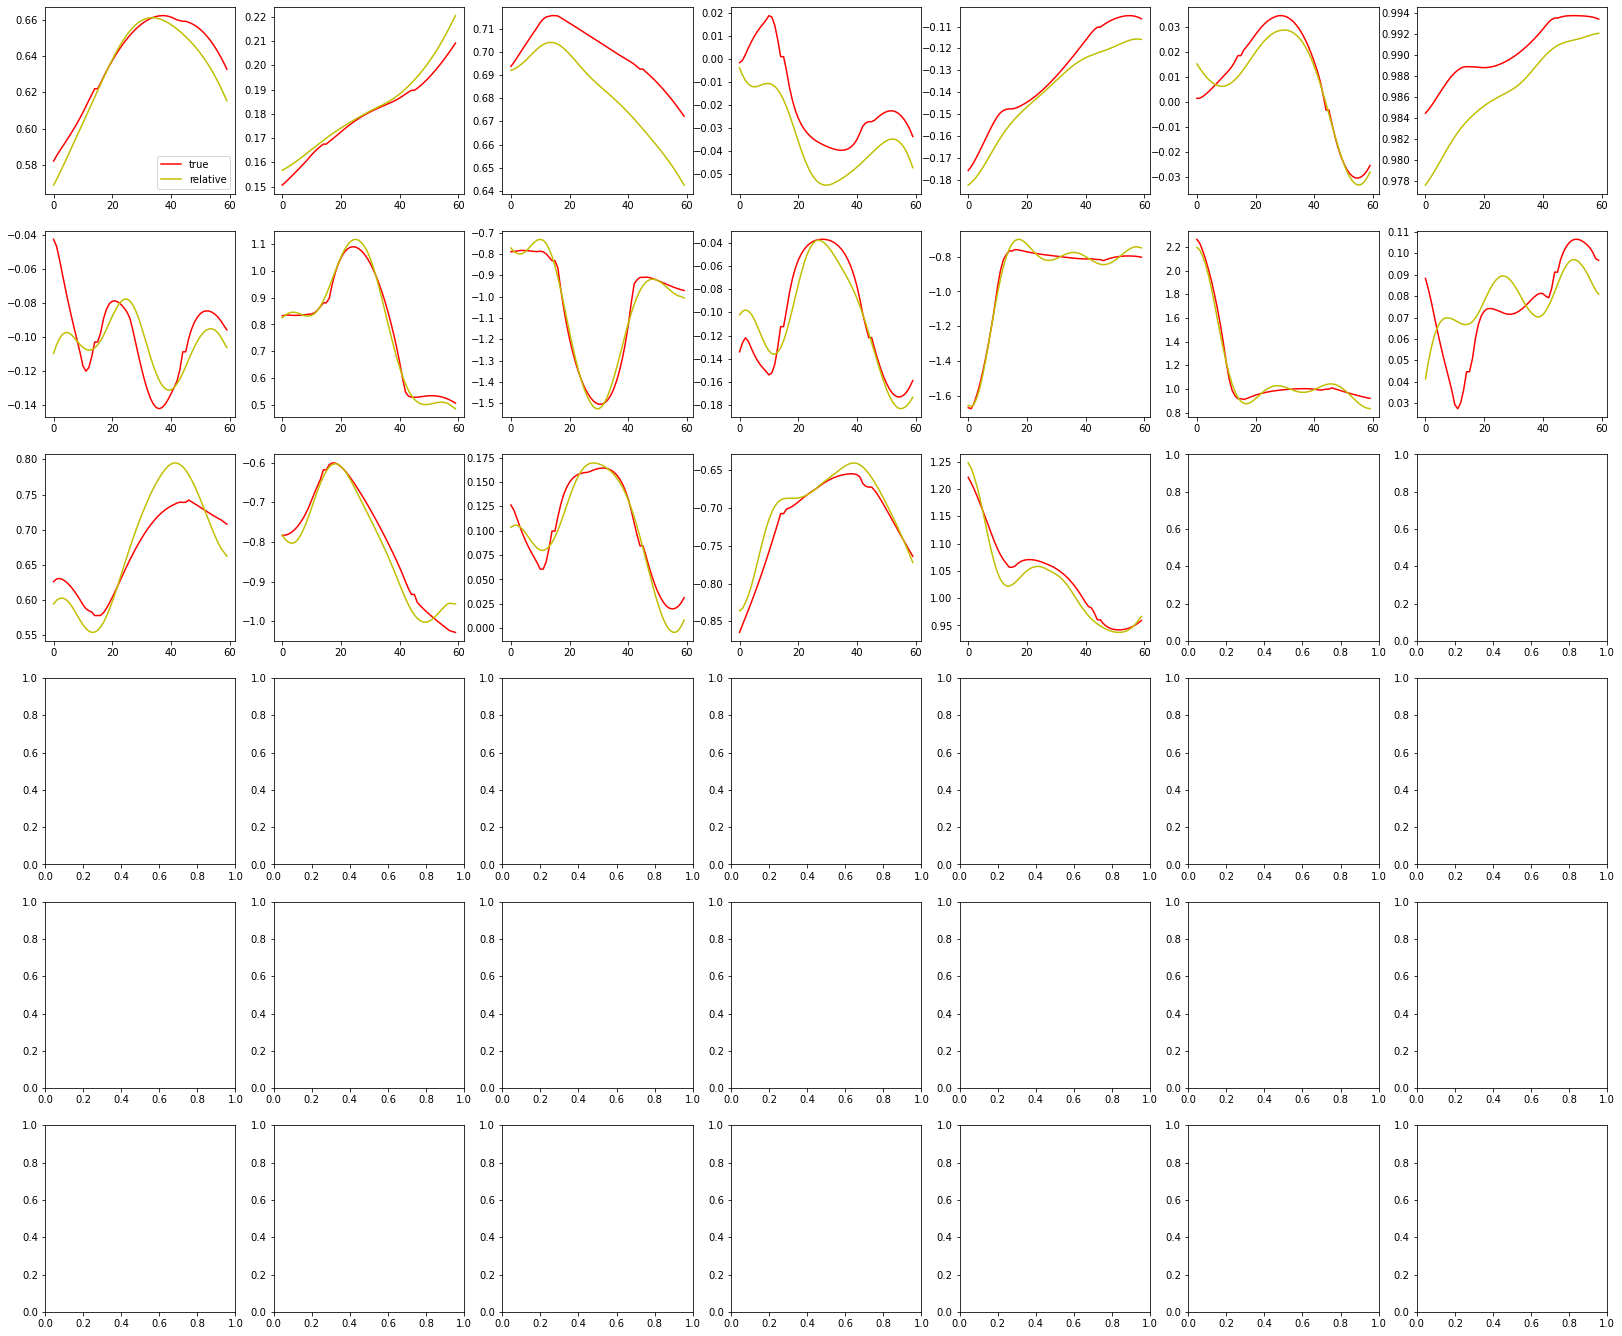

In [82]:
#get random input
use_test_data = True
if use_test_data:
    idx = np.random.randint(len(x_test))
    x = x_test[idx] 
    y = y_test[idx]
else:
    idx = np.random.randint(len(x_train))
    x = x_train[idx]
    y = y_train[idx]

#predict
# y_pred = model_com_traj.predict(x[None,:])
# y_pred_pca = pca.inverse_transform(y_pred).reshape(MPC_HORIZON,D_com)

y_true = y.reshape(-1,D_com)

#relative prediction
y_pred_relative = model_com_traj_relative.predict(x[None,:])
y_pred_pca_relative = pca_relative.inverse_transform(y_pred_relative).reshape(MPC_HORIZON,D_com)

#plot
fig = plot_compare(6, 7, [y_true, y_pred_pca_relative], ['r', 'y', 'b', 'k'], labels=[ 'true', 'relative'])

#### Predicting control

#### Split

In [84]:
x_train_control, x_test_control, y_train_control, y_test_control = train_test_split(x_input_com, x_output_control, test_size = 0.2, random_state = 0)

pca_control = PCA(30)
y_train_pca_control = pca_control.fit_transform(y_train_control)

In [85]:
if to_load:
    pca_control = pickle.load(open(PROJECT_PATH + 'model_direct/pca_control.pkl', 'rb'))
else:
    pickle.dump(pca_control, open(PROJECT_PATH + 'model_direct/pca_control.pkl', 'wb'))

#### Create a model

In [86]:
D_in = x_train_control.shape[1]
D_out = y_train_pca_control.shape[1]

model_control = Sequential([
        GaussianNoise(0.01, input_shape=(D_in,)),
        Dense(256, activation='relu', input_shape=(D_in,)),
        Dense(256, activation='relu'),
        Dense(D_out)]
)

model_control.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.MSE)

In [87]:
if not to_load:
    history = model_control.fit(x_train_control, y_train_pca_control, batch_size=128, epochs=100, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])
    model_control.save(PROJECT_PATH + 'model_direct/predict_control.h5')
else:
    model_control = tf.keras.models.load_model(PROJECT_PATH + 'model_direct/predict_control.h5')

Epoch 1/100
540/540 [==============================] - 1s 1ms/step - loss: 1345.5492 - val_loss: 973.0888
Epoch 2/100
540/540 [==============================] - 1s 1ms/step - loss: 773.2280 - val_loss: 593.5272
Epoch 3/100
540/540 [==============================] - 1s 1ms/step - loss: 516.0890 - val_loss: 462.2160
Epoch 4/100
540/540 [==============================] - 1s 1ms/step - loss: 434.5662 - val_loss: 408.4770
Epoch 5/100
540/540 [==============================] - 1s 1ms/step - loss: 392.7784 - val_loss: 375.8220
Epoch 6/100
540/540 [==============================] - 1s 2ms/step - loss: 363.9196 - val_loss: 349.6487
Epoch 7/100
540/540 [==============================] - 1s 2ms/step - loss: 339.5735 - val_loss: 326.9529
Epoch 8/100
540/540 [==============================] - 1s 2ms/step - loss: 318.3295 - val_loss: 307.1812
Epoch 9/100
540/540 [==============================] - 1s 2ms/step - loss: 300.3577 - val_loss: 291.0450
Epoch 10/100
540/540 [==============================] 

#### Test COM prediction

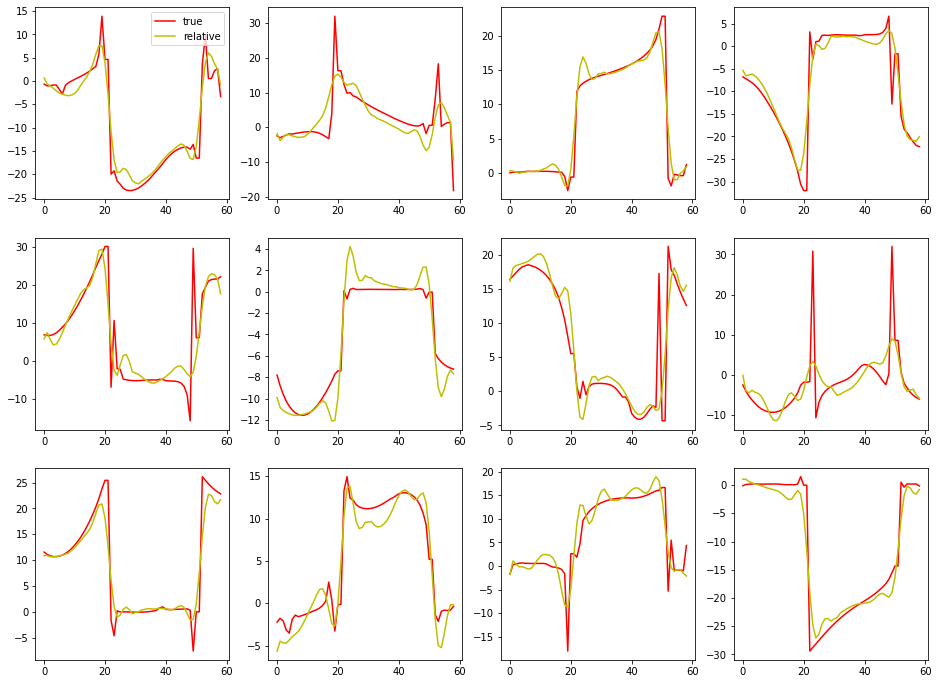

In [90]:
#get random input
use_test_data = True
if use_test_data:
    idx = np.random.randint(len(x_test_control))
    x = x_test_control[idx] 
    y = y_test_control[idx]
else:
    idx = np.random.randint(len(x_train_control))
    x = x_train_control[idx]
    y = y_train_control[idx]

#predict
# y_pred = model_com_traj.predict(x[None,:])
# y_pred_pca = pca.inverse_transform(y_pred).reshape(MPC_HORIZON,D_com)

y_true = y.reshape(-1,D_control)

#relative prediction
y_pred_control = model_control.predict(x[None,:])
y_pred_pca_control = pca_control.inverse_transform(y_pred_control).reshape(MPC_HORIZON-1,D_control)

#plot
fig = plot_compare(3, 4, [y_true, y_pred_pca_control], ['r', 'y', 'b', 'k'], labels=[ 'true', 'relative'])

In [89]:
to_load = False

In [33]:
def predict(t0, x0, plot = False, MPC_HORIZON = 105):
    #construct the input
    mpc_phase, first_interval, contact_pose = extract_mpc_contact_sequence(t0, x0, contact_phases, target_contact_poses, num_of_contact_pose, MPC_HORIZON, rmodel, rdata, total_phase=TOTAL_PHASE, total_pose=TOTAL_POSE)
    contact_input = np.concatenate([mpc_phase, [first_interval], contact_pose])
    x_input = np.concatenate([x0.flatten()[:22], contact_input[:]])[None,:]
#     x_input = np.array([x0.flatten()])[None,:]

    #### Predict the COM traj
    xs_traj = pca.inverse_transform(model_com_traj.__call__(x_input)).reshape(-1,D_com)
    
    #### Predict the control commands
    x = np.hstack([xs_pred[:-1], xs_pred[1:]])
    us_pred = model_u.__call__(x)
    
    #### Plot
    # if plot:
    #     fig,axs = plt.subplots(6,7)
    #     fig.set_size_inches(25, 25)
    #     for idx in range(37):
    #         if idx < 19:
    #             axs[idx//7, idx%7].plot(q_pred[:,idx], '--r', label='pred')
    #         axs[idx//7, idx%7].plot(xs_pred[:,idx], '--g', label='lqt')
    #         axs[idx//7, idx%7].set_title(str(idx))
    #         axs[idx//7, idx%7].legend()
    #     #     plt.show()
    return xs_pred, us_pred

## Test without MPC

In [51]:
#pick one case, and one time step
m = np.random.randint(N)
t0 = np.random.randint(N_MPC_STEPS)
# t0 = 0
xs, us  = xs_set[m], us_set[m]
xs_ref, us_ref = xs_ref_set[m][t0], us_ref_set[m][t0]
cs = data[m]['cs']
gait = create_gait_trot(cs, N_ds, N_ss, stepHeight, ws)

foot_poses = data[m]['foot_poses']

contact_phases = extract_contact_phase(gait, MPC_HORIZON=MPC_HORIZON)

_, target_contact_poses = extract_contact_poses_from_poses(gait, foot_poses.T)

num_of_contact_pose = 6
x0 = xs[t0]

In [36]:
contact_poses =  np.array([([compute_foot_pose(rmodel, rdata,x[:19]) for x in xs_ref_i]) for xs_ref_i in xs_ref_set[m]])

In [37]:
output1 = np.hstack([xs_ref[:,:3], xs_ref[:,19:22]])

output2 = xs_ref
output3 = us_ref

In [38]:
mpc_phase, first_interval, contact_pose = extract_mpc_contact_sequence(t0, x0, contact_phases, target_contact_poses, num_of_contact_pose, MPC_HORIZON, rmodel, rdata, total_phase=TOTAL_PHASE, total_pose=TOTAL_POSE)

In [39]:
contact_input = np.concatenate([mpc_phase[:4], [first_interval], contact_pose])
x_input = np.concatenate([x0.flatten()[:22], contact_input[:]])[None,:]

#### Predict the COM traj
# com_traj = pca.inverse_transform(model_com_traj.__call__(x_input)).reshape(-1,D_com)
# x0_com = np.concatenate([x0[:D_com], x0[19:22], np.zeros(4)])
# com_input, _ = create_lqt_init(lin_sys_com, com_traj, x0_com, com_traj[-1], MPC_HORIZON-1)

#relative prediction
offset = np.concatenate([x_input[0,:3],np.zeros(4)])[None,:]
y_pred_relative = model_com_traj_relative.predict(x_input)
y_pred_pca_relative = pca_relative.inverse_transform(y_pred_relative).reshape(MPC_HORIZON,D_com)+offset

#### Predict the footpose

In [40]:
y_pred = model_foot_traj.predict(x_input)
predicted_footpose = pca_footstep.inverse_transform(y_pred).reshape(MPC_HORIZON,12)


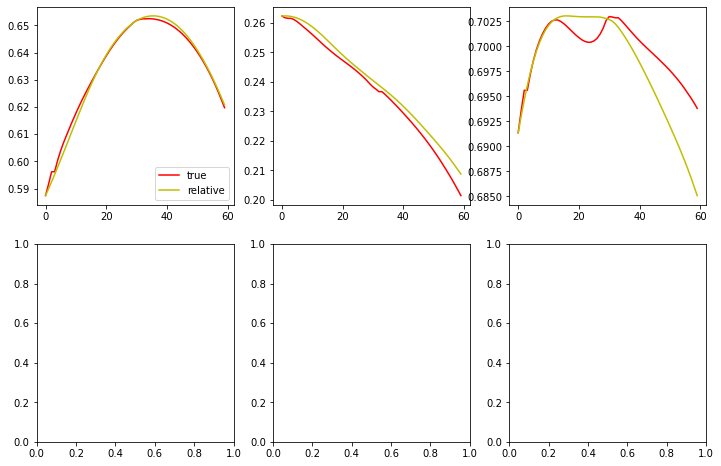

In [41]:
fig = plot_compare(2, 3, [output1[:,:3], y_pred_pca_relative[:,:3]], ['r', 'y',  'b','k'], ['true','relative'])

In [42]:
from anymal_utils import calculate_vel

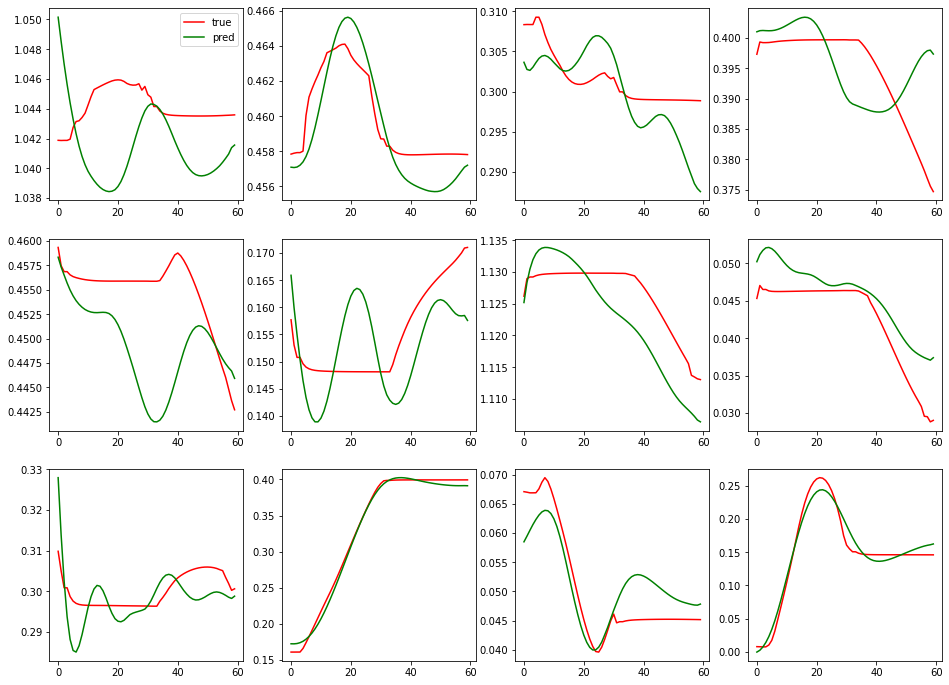

In [43]:
fig = plot_compare(3,4,[contact_poses[t0], predicted_footpose],['r','g'],['true','pred'])

In [44]:
###Get the contact poses for the current MPC
# contact_pose_mpc = contact_poses.T[t0:t0+MPC_HORIZON,:]
# contact_pose_mpc = contact_poses[t0]
contact_pose_mpc = predicted_footpose.copy()
# com_input_noise = com_input + np.random.rand(com_input.shape[0], com_input.shape[1])*0.0001
com_input_noise = y_pred_pca_relative #+ np.random.rand(y_pred_pca_relative.shape[0], com_input.shape[1])*0.0001
dcom_input = np.gradient(y_pred_pca_relative,axis=0)/dt


joint_input = np.concatenate([com_input_noise, dcom_input[:,:3], contact_pose_mpc],axis=1)

#### Predict the configurations
joint_traj = model_config.__call__(joint_input)
q_pred = np.hstack([com_input_noise, joint_traj])

    
dq_pred = calculate_vel(rmodel, q_pred)
xs_pred = np.hstack([q_pred, dq_pred]) 

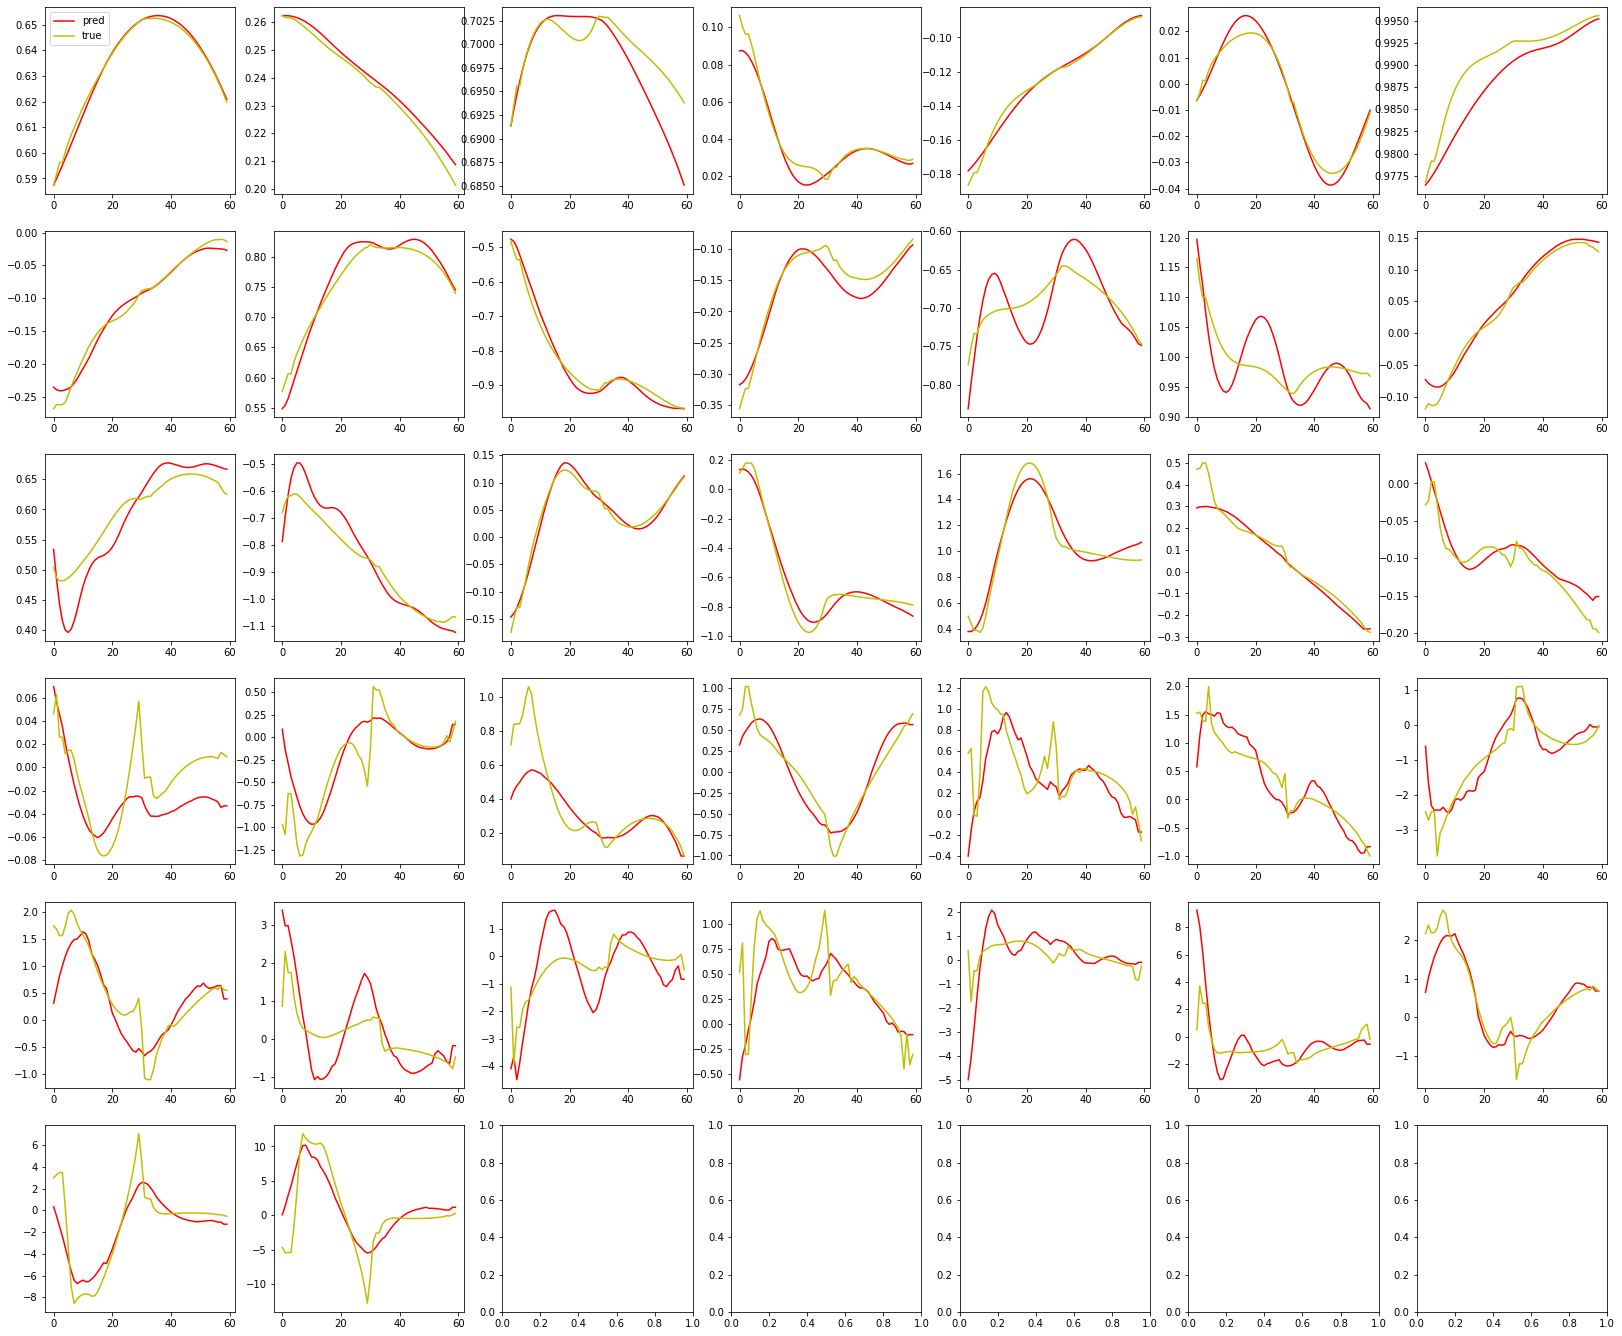

In [45]:
fig = plot_compare(6, 7, [xs_pred, output2], ['r', 'y',  'b','k'], ['pred','true','relative'])

In [382]:
vis_traj_std(xs_pred[:,:19],dt=0.02)

In [383]:
vis_traj_std(output2[:,:19],dt=0.02)

#### MPC_params

In [24]:
# total_data_sl1m = np.load('data/plan_stairs_small_tight.npy', allow_pickle=True)[()]

#### Define MPC parameters
params_caracal = caracal.CaracalParams()
params = caracal.CaracalParams(mpc_filename)
params.solverVerbose = True
params.withForceReg = True
params.withImpulseReg = True
#teguh
params.start_obs_time = 1
params.end_obs_time = 29
params.Qx_JointVel = 1.4

use_obstacle = True
MPC_HORIZON = 60
stepHeight = 0.12
N_ss = 30
N_ds = 45

ws = np.ones((N_ss,2))
ws[:,0] *= 1e6
ws[:,1] *= 1e4
if use_obstacle:
    ws[2:-2] *= 0

In [25]:
from sl1m_env import generate_stair_small, create_obstacle_from_scene
from anymal_utils import Simulator

In [27]:
scene = generate_stair_small()
obstacles = create_obstacle_from_scene(scene)
obstacles[1]['radius'] = 0.1
obstacles[1]['weight'] = 100

## Choose problem

In [29]:
i = 0
data_i = data[i]
filename = filenames[0]
xs = data[i]['xs']
vis_traj_std(np.array(xs)[:,:19], dt=0.01)

In [40]:
# Create the MPC application
# i = np.random.randint(len(data))
i = 0
data_i = data[i]
foot_poses = data_i['foot_poses']
xs, cs, foot_poses = data[i]['xs'], data[i]['cs'], data[i]['foot_poses']
gait = create_gait_trot(cs, N_ds, N_ss, stepHeight, ws)


contact_phases = extract_contact_phase(gait, MPC_HORIZON)
contact_poses, target_contact_poses = extract_contact_poses_from_poses(gait, foot_poses.T, MPC_HORIZON )
q0 = data_i['xs'][0][:19]
print(data_i['n_iter'])

5


## Start MPC

In [90]:
n_iter = 2

In [91]:
#### Initialize MPC
# robot_id, plane_id, env_id = setup_pybullet(urdf_name, env_name)
set_q_std(q0)

In [92]:
params.solverIterations = n_iter
if use_obstacle:
    mpc = caracal.Caracal(q0, rmodel, gait, MPC_HORIZON, params, obstacles)
else:
    mpc = caracal.Caracal(q0, rmodel, gait, MPC_HORIZON, params)

mpc.start(q0, maxiter=100)
simulator = Simulator(mpc, plane_id=plane_id, robot_id=robot_id, rmodel=rmodel)

/usr/local/lib/python3/dist-packages/caracal/mpc.py:556: UserWarning: Deprecated. Use property active_set
  contacts = model.differential.contacts.active
/usr/local/lib/python3/dist-packages/caracal/mpc.py:557: UserWarning: Deprecated. Use property active_set
  nc = len(model.differential.contacts.active)


In [93]:
#### Run MPC
xs_opt,us_opt,ffeas,xs_ref,us_ref  = [],[],[],[],[]
status_finish = True
# try:
q, dq = copy.deepcopy(simulator._q), copy.deepcopy(simulator._v)
x = np.concatenate([q, dq])

for i in range(N_MPC_STEPS*10):
    x, u, feas_i, x_ref, u_ref = simulator.step()
    if np.linalg.norm(x[:3]) > 5:
        raise Exception
    if simulator.i == 1+1:
        xs_opt.append(copy.deepcopy(x))
        us_opt.append(copy.deepcopy(u))
        ffeas.append(copy.deepcopy(feas_i))
        xs_ref.append(copy.deepcopy(x_ref))
        us_ref.append(copy.deepcopy(u_ref))

/usr/local/lib/python3/dist-packages/caracal/mpc.py:556: UserWarning: Deprecated. Use property active_set
  contacts = model.differential.contacts.active
/usr/local/lib/python3/dist-packages/caracal/mpc.py:557: UserWarning: Deprecated. Use property active_set
  nc = len(model.differential.contacts.active)
/usr/local/lib/python3/dist-packages/caracal/mpc.py:548: UserWarning: Deprecated. Use property active_set
  contacts = model.impulses.active
/usr/local/lib/python3/dist-packages/caracal/mpc.py:549: UserWarning: Deprecated. Use property active_set
  nc = len(model.impulses.active)


In [94]:
res = dict()
res['xs_opt'] = xs_opt
res['us_opt'] = xs_opt
res['ffeas'] = xs_opt
res['xs_ref'] = xs_opt
res['us_ref'] = xs_opt
res['xs_0_set'] = xs_0_set
res['us_0_set'] = us_0_set

In [99]:
np.save('data/gianni_second_success_with2iter_withoutmem.npy', res)

In [97]:
vis_traj_std(np.array(xs_opt)[:,:19], dt=0.03)

In [98]:
vis_traj_std(np.array(xs_1iter)[:,:19], dt=0.03)

#### MPC with memory

In [66]:
set_q_std(q0)

In [67]:
n_iter = 2

In [68]:
params.solverIterations = n_iter
if use_obstacle:
    mpc = caracal.Caracal(q0, rmodel, gait, MPC_HORIZON, params, obstacles)
else:
    mpc = caracal.Caracal(q0, rmodel, gait, MPC_HORIZON, params)

mpc.start(q0, maxiter=100)
simulator = Simulator(mpc, plane_id=plane_id, robot_id=robot_id, rmodel=rmodel)

/usr/local/lib/python3/dist-packages/caracal/mpc.py:556: UserWarning: Deprecated. Use property active_set
  contacts = model.differential.contacts.active
/usr/local/lib/python3/dist-packages/caracal/mpc.py:557: UserWarning: Deprecated. Use property active_set
  nc = len(model.differential.contacts.active)


In [69]:
#### Run MPC
xs_opt,us_opt,ffeas,xs_ref,us_ref  = [],[],[],[],[]
xs_0_set, us_0_set = [], []
status_finish = True
# try:
q, dq = copy.deepcopy(simulator._q), copy.deepcopy(simulator._v)
x = np.concatenate([q, dq])

for i in range(N_MPC_STEPS*10):
    if simulator.i == 1:
        xs_0, us_0 = predict(i//10, x, MPC_HORIZON=MPC_HORIZON)
        us_0 = list(np.array(us_0))
        us_prev = list(mpc._solver.us)
        us_prev = us_prev[1:] + [np.zeros(12)]
        for i,u in enumerate(us_prev):
            if len(u) == 0:
                us_0[i] = np.array([])
        if type(mpc._problem.terminalModel) == crocoddyl.ActionModelImpulseFwdDynamics:
            us_0[-1] = np.array([])
        x, u, feas_i, x_ref, u_ref = simulator.step(list(xs_0), list(us_0))
    else:
        x, u, feas_i, x_ref, u_ref = simulator.step()
        
        
    if np.linalg.norm(x[:3]) > 5:
        raise Exception
    if simulator.i == 1+1:
        xs_opt.append(copy.deepcopy(x))
        us_opt.append(copy.deepcopy(u))
        ffeas.append(copy.deepcopy(feas_i))
        xs_ref.append(copy.deepcopy(x_ref))
        us_ref.append(copy.deepcopy(u_ref))
        xs_0_set.append(xs_0)
        us_0_set.append(us_0)

/usr/local/lib/python3/dist-packages/caracal/mpc.py:556: UserWarning: Deprecated. Use property active_set
  contacts = model.differential.contacts.active
/usr/local/lib/python3/dist-packages/caracal/mpc.py:557: UserWarning: Deprecated. Use property active_set
  nc = len(model.differential.contacts.active)
/usr/local/lib/python3/dist-packages/caracal/mpc.py:548: UserWarning: Deprecated. Use property active_set
  contacts = model.impulses.active
/usr/local/lib/python3/dist-packages/caracal/mpc.py:549: UserWarning: Deprecated. Use property active_set
  nc = len(model.impulses.active)


In [70]:
res = dict()
res['xs_opt'] = xs_opt
res['us_opt'] = xs_opt
res['ffeas'] = xs_opt
res['xs_ref'] = xs_opt
res['us_ref'] = xs_opt
res['xs_0_set'] = xs_0_set
res['us_0_set'] = us_0_set

In [71]:
np.save('data/gianni_second_success_with2iter_withoutmem.npy', res)

In [83]:
vis_traj_std(np.array(xs_0_set[550])[:,:19], dt=0.03)